In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import itertools
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def balance_train_data(df, label, group_lbl, count_lbl, random_state):
    df_grp = df.groupby([group_lbl])[group_lbl].count().reset_index(name="count")
    mean_count = int(df_grp.drop(df_grp[df_grp[group_lbl] == label].index)["count"].mean().round())

    df_label = df[df[group_lbl] == label].sample(n=mean_count, random_state=random_state)
    df_other = df.drop(df[df[group_lbl] == label].index)

    df_all = pd.concat([df_other, df_label], axis=0)
  
    return df_all.reset_index(drop=True)

In [4]:
data_dir = "~/siads696/data"

embed_dataset =  "bbbc021_image_embed_compact_batchcorr.csv"
train_test_split = "compound_moas_trainVtest.csv"

train_data_moa_file = "full_train_moa.parquet"
train_data_cmpd_file = "full_train_cmpd.parquet"
test_data_file = "full_test.parquet"

random_state = 764

In [5]:
df_dataset = pd.read_csv(os.path.join(data_dir, embed_dataset), dtype={"Metadata_MoA": "str", "Metadata_SMILES": "str"})

print(f"Embedding vector dataset shape: {df_dataset.shape}")
print(f"Embedding vectors MoA assigned: {df_dataset[~df_dataset['Metadata_MoA'].isnull()].shape[0]}")

Embedding vector dataset shape: (13200, 3081)
Embedding vectors MoA assigned: 6160


In [6]:
df_train_test = pd.read_csv(os.path.join(data_dir, train_test_split))
df_train = df_train_test[~df_train_test["in_testset"]]
df_test = df_train_test[df_train_test["in_testset"]]

In [7]:
print(f"Train/test set shape: {df_train_test.shape}")
print(f"Training set shape: {df_train.shape}")
print(f"Test set shape: {df_test.shape}")
print(f"\nMoA in training set:\n {", ".join(df_train['MoA'].unique().tolist())}")
print(f"\nMoA in test set:\n {", ".join(df_test['MoA'].unique().tolist())}")
print(f"\nCompounds in training set:\n {", ".join(df_train['Compound'].unique().tolist())}")
print(f"\nCompounds in test set:\n {", ".join(df_test['Compound'].unique().tolist())}")

Train/test set shape: (39, 4)
Training set shape: (29, 4)
Test set shape: (10, 4)

MoA in training set:
 Actin disruptors, Aurora kinase inhibitors, Cholesterol-lowering, DMSO, DNA damage, DNA replication, Eg5 inhibitors, Epithelial, Kinase inhibitors, Microtubule destabilizers, Microtubule stabilizers, Protein degradation, Protein synthesis

MoA in test set:
 Actin disruptors, Aurora kinase inhibitors, DNA damage, DNA replication, Epithelial, Kinase inhibitors, Microtubule destabilizers, Microtubule stabilizers, Protein degradation, Protein synthesis

Compounds in training set:
 cytochalasin B, cytochalasin D, AZ-A, AZ258, mevinolin/lovastatin, simvastatin, DMSO, chlorambucil, cisplatin, etoposide, camptothecin, floxuridine, methotrexate, AZ-C, AZ138, AZ-J, AZ-U, PD-169316, alsterpaullone, colchicine, demecolcine, nocodazole, docetaxel, epothilone B, ALLN, MG-132, lactacystin, anisomycin, cyclohexamide

Compounds in test set:
 latrunculin B, AZ841, mitomycin C, mitoxantrone, PP-2, bry

In [8]:
df_data_train = df_dataset.merge(df_train, left_on="Metadata_Compound", right_on="Compound", how="inner")
df_data_test = df_dataset.merge(df_test, left_on="Metadata_Compound", right_on="Compound", how="inner")

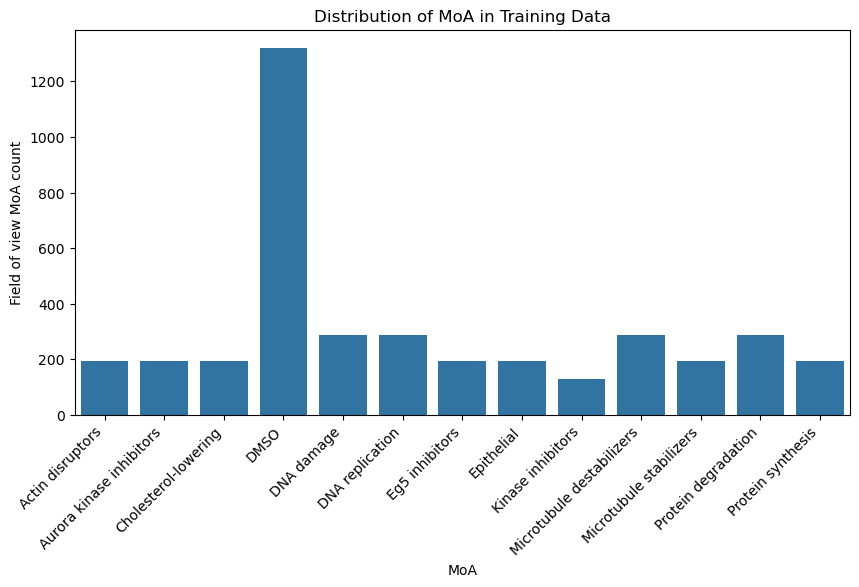

In [9]:
df_moa_count = df_data_train.groupby(["Metadata_MoA"])["Metadata_Compound"].count().reset_index(name="MoA_count")
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x="Metadata_MoA", y="MoA_count", data=df_moa_count, orient="v", ax=ax)
ax.set_ylabel("Field of view MoA count")
ax.set_xlabel("MoA")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of MoA in Training Data")
plt.show()

In [10]:
print(f"Training data shape before balancing: {df_data_train.shape}")
df_data_moa_train = balance_train_data(df_data_train, "DMSO", "Metadata_MoA", "Metadata_Compound", random_state)
print(f"Training data shape after balancing: {df_data_moa_train.shape}")

Training data shape before balancing: (3944, 3085)
Training data shape after balancing: (2843, 3085)


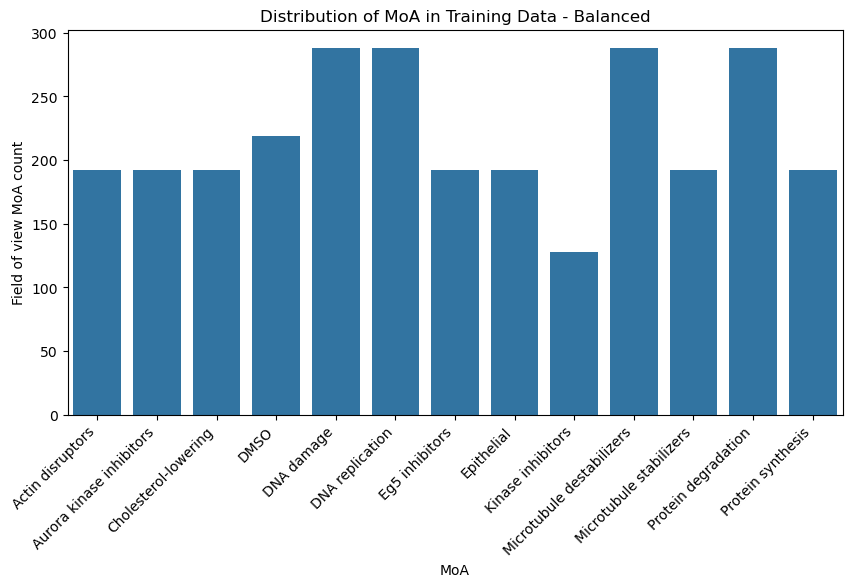

In [11]:
df_moa_count = df_data_moa_train.groupby(["Metadata_MoA"])["Metadata_Compound"].count().reset_index(name="MoA_count")
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x="Metadata_MoA", y="MoA_count", data=df_moa_count, orient="v", ax=ax)
ax.set_ylabel("Field of view MoA count")
ax.set_xlabel("MoA")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of MoA in Training Data - Balanced")
plt.show()

In [12]:
df_data_moa_train.to_parquet(os.path.join(data_dir, train_data_moa_file), index=False)

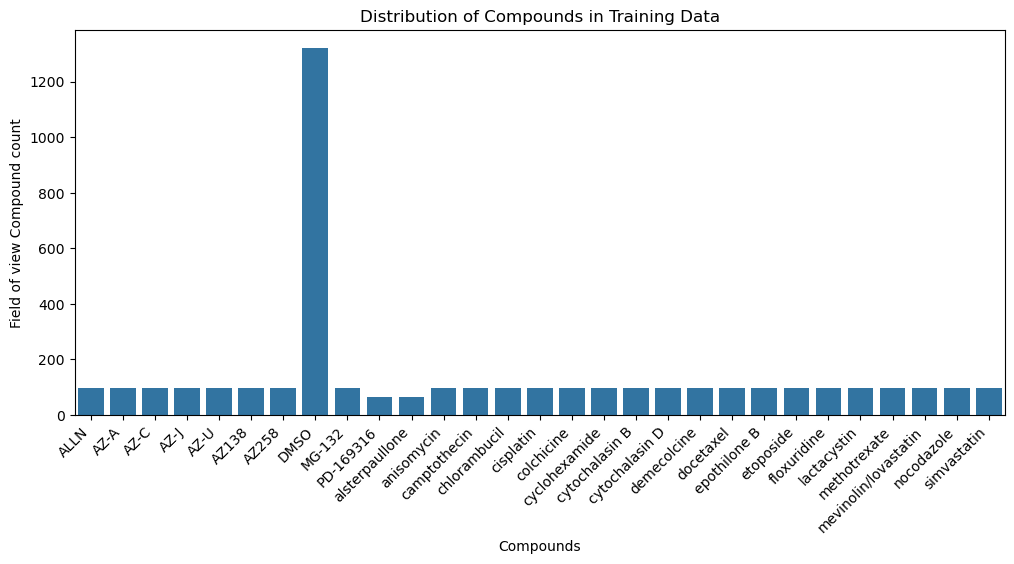

In [13]:
compound_count = df_data_train.groupby(["Metadata_Compound"])["Metadata_MoA"].count().reset_index(name="Compound_count")
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x="Metadata_Compound", y="Compound_count", data=compound_count, orient="v", ax=ax)
ax.set_ylabel("Field of view Compound count")
ax.set_xlabel("Compounds")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Compounds in Training Data")
plt.show()

In [14]:
print(f"Training data shape before balancing: {df_data_train.shape}")
df_data_cmpd_train = balance_train_data(df_data_train, "DMSO", "Metadata_Compound", "Metadata_MoA", random_state)
print(f"Training data shape after balancing: {df_data_cmpd_train.shape}")

Training data shape before balancing: (3944, 3085)
Training data shape after balancing: (2718, 3085)


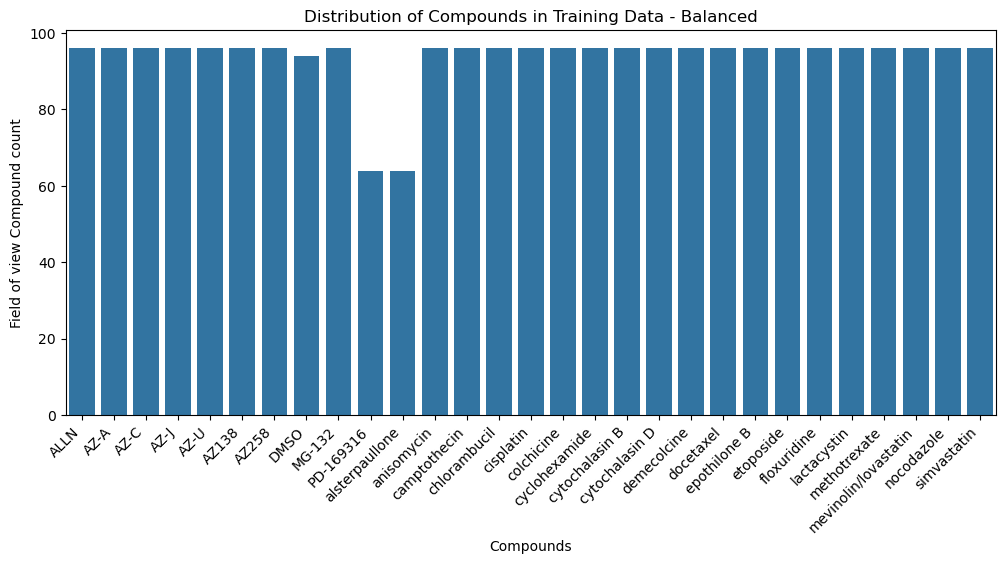

In [15]:
compound_count = df_data_cmpd_train.groupby(["Metadata_Compound"])["Metadata_MoA"].count().reset_index(name="Compound_count")
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x="Metadata_Compound", y="Compound_count", data=compound_count, orient="v", ax=ax)
ax.set_ylabel("Field of view Compound count")
ax.set_xlabel("Compounds")
plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Compounds in Training Data - Balanced")
plt.show()

In [16]:
df_data_cmpd_train.to_parquet(os.path.join(data_dir, train_data_cmpd_file), index=False)

In [17]:
print(f"Test data shape: {df_data_test.shape}")

Test data shape: (2216, 3085)


In [18]:
df_data_test.to_parquet(os.path.join(data_dir, test_data_file), index=False)